<a href="https://colab.research.google.com/github/ShreshthSaxena/Algorithmic-Trading/blob/master/Market_Indicators_(Kaggle_NYSE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras.optimizers import Adam
import keras
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math, time
import tensorflow as tf
from pandas_datareader import data as pdr
from keras import optimizers
from keras.callbacks import *
#from clr_callback import *
import fix_yahoo_finance

Using TensorFlow backend.


In [0]:
!git clone https://github.com/bckenstler/CLR
%cd CLR
from clr_callback import *

Cloning into 'CLR'...
remote: Enumerating objects: 244, done.
remote: Total 244 (delta 0), reused 0 (delta 0), pack-reused 244
Receiving objects: 100% (244/244), 1.37 MiB | 3.65 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/CLR


In [0]:
df = pdr.get_data_yahoo('^GSPC', start=datetime.datetime(2000, 1, 4), end=datetime.datetime(2017, 7, 27))
df = df.drop(['Close'],1)
df.columns = ['high', 'low', 'open', 'volume', 'adj close']
df.reset_index(inplace = True)
df.head()

,Date,high,low,open,volume,adj close
0,2000-01-04,1455.219971,1397.430054,1455.219971,1009000000,1399.420044
1,2000-01-05,1413.270020,1377.680054,1399.420044,1085500000,1402.109985
2,2000-01-06,1411.900024,1392.099976,1402.109985,1092300000,1403.449951
3,2000-01-07,1441.469971,1400.729980,1403.449951,1225200000,1441.469971
4,2000-01-10,1464.359985,1441.469971,1441.469971,1064800000,1457.599976


In [0]:
def ema(data, period=0.5, column='adj close'):
    data['ema' + str(period)] = data[column].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()
    
    return data
df= ema(df)

def macd(data, period_long=26, period_short=12, period_signal=9, column='adj close'):
    remove_cols = []
    if not 'ema' + str(period_long) in data.columns:
        data = ema(data, period_long)
        remove_cols.append('ema' + str(period_long))

    if not 'ema' + str(period_short) in data.columns:
        data = ema(data, period_short)
        remove_cols.append('ema' + str(period_short))

    data['macd_val'] = data['ema' + str(period_short)] - data['ema' + str(period_long)]
    data['macd_signal_line'] = data['macd_val'].ewm(ignore_na=False, min_periods=0, com=period_signal, adjust=True).mean()

    data = data.drop(remove_cols, axis=1)
        
    return data
df= macd(df)
def acc_dist(data, trend_periods=21, open_col='open', high_col='high', low_col='low', close_col='adj close', vol_col='volume'):
    for index, row in data.iterrows():
        if row[high_col] != row[low_col]:
            ac = ((row[close_col] - row[low_col]) - (row[high_col] - row[close_col])) / (row[high_col] - row[low_col]) * row[vol_col]
        else:
            ac = 0
        data.set_value(index, 'acc_dist', ac)
    data['acc_dist_ema' + str(trend_periods)] = data['acc_dist'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    
    return data
df= acc_dist(df)
def on_balance_volume(data, trend_periods=21, close_col='adj close', vol_col='volume'):
    for index, row in data.iterrows():
        if index:
            last_obv = data.at[index - 1, 'obv']
            if row[close_col] > data.at[index - 1, close_col]:
                current_obv = last_obv + row[vol_col]
            elif row[close_col] < data.at[index - 1, close_col]:
                current_obv = last_obv - row[vol_col]
            else:
                current_obv = last_obv
        else:
            last_obv = 0
            current_obv = row[vol_col]

        data.set_value(index, 'obv', current_obv)

    data['obv_ema' + str(trend_periods)] = data['obv'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    
    return data
df= on_balance_volume(df)
def price_volume_trend(data, trend_periods=21, close_col='adj close', vol_col='volume'):
    for index, row in data.iterrows():
        if index > 0:
            last_val = data.at[index - 1, 'pvt']
            last_close = data.at[index - 1, close_col]
            today_close = row[close_col]
            today_vol = row[vol_col]
            current_val = last_val + (today_vol * (today_close - last_close) / last_close)
        else:
            current_val = row[vol_col]

        data.set_value(index, 'pvt', current_val)

    data['pvt_ema' + str(trend_periods)] = data['pvt'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
        
    return data
df= price_volume_trend(df)
def average_true_range(data, trend_periods=14, open_col='open', high_col='high', low_col='low', close_col='adj close', drop_tr = True):
    for index, row in data.iterrows():
        prices = [row[high_col], row[low_col], row[close_col], row[open_col]]
        if index > 0:
            val1 = np.amax(prices) - np.amin(prices)
            val2 = abs(np.amax(prices) - data.at[index - 1, close_col])
            val3 = abs(np.amin(prices) - data.at[index - 1, close_col])
            true_range = np.amax([val1, val2, val3])

        else:
            true_range = np.amax(prices) - np.amin(prices)

        data.set_value(index, 'true_range', true_range)
    data['atr'] = data['true_range'].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    if drop_tr:
        data = data.drop(['true_range'], axis=1)
        
    return data
df= average_true_range(df)
def bollinger_bands(data, trend_periods=20, close_col='adj close'):

    data['bol_bands_middle'] = data[close_col].ewm(ignore_na=False, min_periods=0, com=trend_periods, adjust=True).mean()
    for index, row in data.iterrows():

        s = data[close_col].iloc[index - trend_periods: index]
        sums = 0
        middle_band = data.at[index, 'bol_bands_middle']
        for e in s:
            sums += np.square(e - middle_band)

        std = np.sqrt(sums / trend_periods)
        d = 2
        upper_band = middle_band + (d * std)
        lower_band = middle_band - (d * std)

        data.set_value(index, 'bol_bands_upper', upper_band)
        data.set_value(index, 'bol_bands_lower', lower_band)

    return data
df= bollinger_bands(df)
def chaikin_oscillator(data, periods_short=3, periods_long=10, high_col='high',
                       low_col='low', close_col='adj close', vol_col='volume'):
    ac = pd.Series([])
    val_last = 0
    for index, row in data.iterrows():
        if row[high_col] != row[low_col]:
            val = val_last + ((row[close_col] - row[low_col]) - (row[high_col] - row[close_col])) / (row[high_col] - row[low_col]) * row[vol_col]
        else:
            val = val_last
        ac.set_value(index, val)
    val_last = val
    ema_long = ac.ewm(ignore_na=False, min_periods=0, com=periods_long, adjust=True).mean()
    ema_short = ac.ewm(ignore_na=False, min_periods=0, com=periods_short, adjust=True).mean()
    data['ch_osc'] = ema_short - ema_long

    return data
df= chaikin_oscillator(df)
def typical_price(data, high_col = 'high', low_col = 'low', close_col = 'adj close'):
    
    data['typical_price'] = (data[high_col] + data[low_col] + data[close_col]) / 3

    return data
df= typical_price(df)
def ease_of_movement(data, period=14, high_col='high', low_col='low', vol_col='volume'):
    for index, row in data.iterrows():
        if index > 0:
            midpoint_move = (row[high_col] + row[low_col]) / 2 - (data.at[index - 1, high_col] + data.at[index - 1, low_col]) / 2
        else:
            midpoint_move = 0
        
        diff = row[high_col] - row[low_col]

        if diff == 0:
            #this is to avoid division by zero below
            diff = 0.000000001
            
        vol = row[vol_col]
        if vol == 0:
            vol = 1
        box_ratio = (vol / 100000000) / (diff)
        emv = midpoint_move / box_ratio
        
        data.set_value(index, 'emv', emv)
        
    data['emv_ema_'+str(period)] = data['emv'].ewm(ignore_na=False, min_periods=0, com=period, adjust=True).mean()
        
    return data
df= ease_of_movement(df)
def mass_index(data, period=25, ema_period=9, high_col='high', low_col='low'):
    high_low = data[high_col] - data[low_col] + 0.000001	#this is to avoid division by zero below
    ema = high_low.ewm(ignore_na=False, min_periods=0, com=ema_period, adjust=True).mean()
    ema_ema = ema.ewm(ignore_na=False, min_periods=0, com=ema_period, adjust=True).mean()
    div = ema / ema_ema

    for index, row in data.iterrows():
        if index >= period:
            val = div[index-25:index].sum()
        else:
            val = 0
        data.set_value(index, 'mass_index', val)
         
    return data
df= mass_index(df)
def directional_movement_index(data, periods=14, high_col='high', low_col='low'):
    remove_tr_col = False
    if not 'true_range' in data.columns:
        data = average_true_range(data, drop_tr = False)
        remove_tr_col = True

    data['m_plus'] = 0.
    data['m_minus'] = 0.
    
    for i,row in data.iterrows():
        if i>0:
            data.set_value(i, 'm_plus', row[high_col] - data.at[i-1, high_col])
            data.set_value(i, 'm_minus', row[low_col] - data.at[i-1, low_col])
    
    data['dm_plus'] = 0.
    data['dm_minus'] = 0.
    
    for i,row in data.iterrows():
        if row['m_plus'] > row['m_minus'] and row['m_plus'] > 0:
            data.set_value(i, 'dm_plus', row['m_plus'])
            
        if row['m_minus'] > row['m_plus'] and row['m_minus'] > 0:
            data.set_value(i, 'dm_minus', row['m_minus'])
    
    data['di_plus'] = (data['dm_plus'] / data['true_range']).ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    data['di_minus'] = (data['dm_minus'] / data['true_range']).ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    
    data['dxi'] = np.abs(data['di_plus'] - data['di_minus']) / (data['di_plus'] + data['di_minus'])
    data.set_value(0, 'dxi',1.)
    data['adx'] = data['dxi'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    data = data.drop(['m_plus', 'm_minus', 'dm_plus', 'dm_minus'], axis=1)
    if remove_tr_col:
        data = data.drop(['true_range'], axis=1)
         
    return data
df= directional_movement_index(df)

def money_flow_index(data, periods=14, vol_col='volume'):
    remove_tp_col = False
    if not 'typical_price' in data.columns:
        data = typical_price(data)
        remove_tp_col = True
    
    data['money_flow'] = data['typical_price'] * data[vol_col]
    data['money_ratio'] = 0.
    data['money_flow_index'] = 0.
    data['money_flow_positive'] = 0.
    data['money_flow_negative'] = 0.
    
    for index,row in data.iterrows():
        if index > 0:
            if row['typical_price'] < data.at[index-1, 'typical_price']:
                data.set_value(index, 'money_flow_positive', row['money_flow'])
            else:
                data.set_value(index, 'money_flow_negative', row['money_flow'])
    
        if index >= periods:
            period_slice = data['money_flow'][index-periods:index]
            positive_sum = data['money_flow_positive'][index-periods:index].sum()
            negative_sum = data['money_flow_negative'][index-periods:index].sum()

            if negative_sum == 0.:
                #this is to avoid division by zero below
                negative_sum = 0.00001
            m_r = positive_sum / negative_sum

            mfi = 1-(1 / (1 + m_r))

            data.set_value(index, 'money_ratio', m_r)
            data.set_value(index, 'money_flow_index', mfi)
          
    data = data.drop(['money_flow', 'money_ratio', 'money_flow_positive', 'money_flow_negative'], axis=1)
    
    if remove_tp_col:
        data = data.drop(['typical_price'], axis=1)

    return data
df= money_flow_index(df)

def negative_volume_index(data, periods=255, close_col='adj close', vol_col='volume'):
    data['nvi'] = 0.
    
    for index,row in data.iterrows():
        if index > 0:
            prev_nvi = data.at[index-1, 'nvi']
            prev_close = data.at[index-1, close_col]
            if row[vol_col] < data.at[index-1, vol_col]:
                nvi = prev_nvi + (row[close_col] - prev_close / prev_close * prev_nvi)
            else: 
                nvi = prev_nvi
        else:
            nvi = 1000
        data.set_value(index, 'nvi', nvi)
    data['nvi_ema'] = data['nvi'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    
    return data
df= negative_volume_index(df)
def positive_volume_index(data, periods=255, close_col='adj close', vol_col='volume'):
    data['pvi'] = 0.
    
    for index,row in data.iterrows():
        if index > 0:
            prev_pvi = data.at[index-1, 'pvi']
            prev_close = data.at[index-1, close_col]
            if row[vol_col] > data.at[index-1, vol_col]:
                pvi = prev_pvi + (row[close_col] - prev_close / prev_close * prev_pvi)
            else: 
                pvi = prev_pvi
        else:
            pvi = 1000
        data.set_value(index, 'pvi', pvi)
    data['pvi_ema'] = data['pvi'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()

    return data
df= positive_volume_index(df)
def momentum(data, periods=14, close_col='adj close'):
    data['momentum'] = 0.
    
    for index,row in data.iterrows():
        if index >= periods:
            prev_close = data.at[index-periods, close_col]
            val_perc = (row[close_col] - prev_close)/prev_close

            data.set_value(index, 'momentum', val_perc)

    return data
df= momentum(df)
def rsi(data, periods=14, close_col='adj close'):
    data['rsi_u'] = 0.
    data['rsi_d'] = 0.
    data['rsi'] = 0.
    
    for index,row in data.iterrows():
        if index >= periods:
            
            prev_close = data.at[index-periods, close_col]
            if prev_close < row[close_col]:
                data.set_value(index, 'rsi_u', row[close_col] - prev_close)
            elif prev_close > row[close_col]:
                data.set_value(index, 'rsi_d', prev_close - row[close_col])
            
    data['rsi'] = data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() / (data['rsi_u'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean() + data['rsi_d'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean())
    
    data = data.drop(['rsi_u', 'rsi_d'], axis=1)
        
    return data
df= rsi(df)
def chaikin_volatility(data, ema_periods=10, change_periods=10, high_col='high', low_col='low', close_col='adj close'):
    data['ch_vol_hl'] = data[high_col] - data[low_col]
    data['ch_vol_ema'] = data['ch_vol_hl'].ewm(ignore_na=False, min_periods=0, com=ema_periods, adjust=True).mean()
    data['chaikin_volatility'] = 0.
    
    for index,row in data.iterrows():
        if index >= change_periods:
            
            prev_value = data.at[index-change_periods, 'ch_vol_ema']
            if prev_value == 0:
                #this is to avoid division by zero below
                prev_value = 0.0001
            data.set_value(index, 'chaikin_volatility', ((row['ch_vol_ema'] - prev_value)/prev_value))
            
    data = data.drop(['ch_vol_hl', 'ch_vol_ema'], axis=1)
        
    return data
df= chaikin_volatility(df)
def williams_ad(data, high_col='high', low_col='low', close_col='adj close'):
    data['williams_ad'] = 0.
    
    for index,row in data.iterrows():
        if index > 0:
            prev_value = data.at[index-1, 'williams_ad']
            prev_close = data.at[index-1, close_col]
            if row[close_col] > prev_close:
                ad = row[close_col] - min(prev_close, row[low_col])
            elif row[close_col] < prev_close:
                ad = row[close_col] - max(prev_close, row[high_col])
            else:
                ad = 0.
                                                                                                        
            data.set_value(index, 'williams_ad', (ad+prev_value))
        
    return data
df= williams_ad(df)
def williams_r(data, periods=14, high_col='high', low_col='low', close_col='adj close'):
    data['williams_r'] = 0.
    
    for index,row in data.iterrows():
        if index > periods:
            data.set_value(index, 'williams_r', ((max(data[high_col][index-periods:index]) - row[close_col]) / 
                                                 (max(data[high_col][index-periods:index]) - min(data[low_col][index-periods:index]))))
        
    return data
df= williams_r(df)
def trix(data, periods=14, signal_periods=9, close_col='adj close'):
    data['trix'] = data[close_col].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    data['trix'] = data['trix'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    data['trix'] = data['trix'].ewm(ignore_na=False, min_periods=0, com=periods, adjust=True).mean()
    data['trix_signal'] = data['trix'].ewm(ignore_na=False, min_periods=0, com=signal_periods, adjust=True).mean()
        
    return data
df= trix(df)
def ultimate_oscillator(data, period_1=7,period_2=14, period_3=28, high_col='high', low_col='low', close_col='adj close'):
    data['ultimate_oscillator'] = 0.
    data['uo_bp'] = 0.
    data['uo_tr'] = 0.
    data['uo_avg_1'] = 0.
    data['uo_avg_2'] = 0.
    data['uo_avg_3'] = 0.

    for index,row in data.iterrows():
        if index > 0:
                           
            bp = row[close_col] - min(row[low_col], data.at[index-1, close_col])
            tr = max(row[high_col], data.at[index-1, close_col]) - min(row[low_col], data.at[index-1, close_col])
            
            data.set_value(index, 'uo_bp', bp)
            data.set_value(index, 'uo_tr', tr)
            if index >= period_1:
                uo_avg_1 = sum(data['uo_bp'][index-period_1:index]) / sum(data['uo_tr'][index-period_1:index])
                data.set_value(index, 'uo_avg_1', uo_avg_1)
            if index >= period_2:
                uo_avg_2 = sum(data['uo_bp'][index-period_2:index]) / sum(data['uo_tr'][index-period_2:index])
                data.set_value(index, 'uo_avg_2', uo_avg_2)
            if index >= period_3:
                uo_avg_3 = sum(data['uo_bp'][index-period_3:index]) / sum(data['uo_tr'][index-period_3:index])
                data.set_value(index, 'uo_avg_3', uo_avg_3)
                uo = (4 * uo_avg_1 + 2 * uo_avg_2 + uo_avg_3) / 7
                data.set_value(index, 'ultimate_oscillator', uo)

    data = data.drop(['uo_bp', 'uo_tr', 'uo_avg_1', 'uo_avg_2', 'uo_avg_3'], axis=1)
        
    return data
df= ultimate_oscillator(df)

In [0]:
df["close"] = df['adj close'] # Moving close to the last column
df.drop(['adj close'], 1, inplace=True) # Moving close to the last column
df.head()

,Date,high,low,open,volume,ema0.5,macd_val,macd_signal_line,acc_dist,acc_dist_ema21,obv,obv_ema21,pvt,pvt_ema21,atr,bol_bands_middle,bol_bands_upper,bol_bands_lower,ch_osc,typical_price,emv,emv_ema_14,mass_index,di_plus,di_minus,dxi,adx,money_flow_index,nvi,nvi_ema,pvi,pvi_ema,momentum,rsi,chaikin_volatility,williams_ad,williams_r,trix,trix_signal,ultimate_oscillator,close
0,2000-01-04,1455.219971,1397.430054,1455.219971,1009000000,1399.420044,NaN,NaN,-9.395104e+08,-9.395104e+08,1.009000e+09,1.009000e+09,1.009000e+09,1.009000e+09,57.789917,1399.420044,1399.420044,1399.420044,0.000000e+00,1417.356689,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,0.0,1000.000000,1000.000000,1000.000000,1000.000000,0.0,NaN,0.0,0.000000,0.0,1399.420044,1399.420044,0.0,1399.420044
1,2000-01-05,1413.270020,1377.680054,1399.420044,1085500000,1401.437500,NaN,NaN,4.047341e+08,-2.517574e+08,2.094500e+09,1.564372e+09,1.011087e+09,1.010068e+09,46.307184,1400.797819,1400.797819,1400.797819,6.401164e+07,1397.686686,-101.146898,-52.317361,0.0,0.000000,0.000000,NaN,1.000000,0.0,1000.000000,1000.000000,1402.109985,1201.448447,0.0,NaN,0.0,24.429932,0.0,1399.792284,1399.615960,0.0,1402.109985
2,2000-01-06,1411.900024,1392.099976,1402.109985,1092300000,1402.830735,NaN,NaN,1.599776e+08,-1.080806e+08,3.186800e+09,2.130526e+09,1.012130e+09,1.010787e+09,36.855353,1401.725329,1401.725329,1401.725329,6.277004e+07,1402.483317,11.827757,-29.444696,0.0,0.000000,0.259687,1.000000,1.000000,0.0,1000.000000,1000.000000,1403.449951,1269.045991,0.0,NaN,0.0,35.779907,0.0,1400.121196,1399.802394,0.0,1403.449951
3,2000-01-07,1441.469971,1400.729980,1403.449951,1225200000,1428.912219,NaN,NaN,1.225200e+09,2.488464e+08,4.412000e+09,2.741290e+09,1.045322e+09,1.020032e+09,37.929204,1412.400052,1412.400052,1412.400052,1.436807e+08,1427.889974,63.510677,-3.748539,0.0,0.200643,0.187900,0.032796,0.647825,0.0,1000.000000,1000.000000,1441.469971,1312.405384,0.0,NaN,0.0,76.519897,0.0,1401.203553,1400.209826,0.0,1441.469971
4,2000-01-10,1464.359985,1441.469971,1441.469971,1064800000,1448.116420,NaN,NaN,4.358744e+08,2.898106e+08,5.476800e+09,3.340440e+09,1.057237e+09,1.028181e+09,34.492709,1422.342950,1422.342950,1422.342950,1.097177e+08,1454.476644,68.392738,12.735937,0.0,0.154795,0.551657,0.561767,0.623673,0.0,1457.599976,1092.237793,1441.469971,1338.420754,0.0,NaN,0.0,92.649902,0.0,1402.840231,1400.852156,0.0,1457.599976


In [0]:
df.set_index('Date', inplace = True)

NORMALIZATION

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()
def normalize(df):
    df = min_max_scaler.fit_transform(df.values.reshape(-1,1))
    return df
for i in df.columns:
    df[i] = normalize(df[i])
df.describe()

,high,low,open,volume,ema0.5,macd_val,macd_signal_line,acc_dist,acc_dist_ema21,obv,obv_ema21,pvt,pvt_ema21,atr,bol_bands_middle,bol_bands_upper,bol_bands_lower,ch_osc,typical_price,emv,emv_ema_14,mass_index,di_plus,di_minus,dxi,adx,money_flow_index,nvi,nvi_ema,pvi,pvi_ema,momentum,rsi,chaikin_volatility,williams_ad,williams_r,trix,trix_signal,ultimate_oscillator,close
count,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4394.000000,4394.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4418.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4405.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000,4419.000000
mean,0.403274,0.404998,0.404169,0.241130,0.405386,0.739294,0.734642,0.520420,0.514665,0.418099,0.416726,0.699303,0.634115,0.180836,0.375316,0.367482,0.396458,0.521615,0.404363,0.715604,0.684841,0.758359,0.496996,0.475165,0.371485,0.318662,0.499557,0.406504,0.301715,0.393494,0.301262,0.561995,0.591328,0.304714,0.386182,0.385836,0.370108,0.369504,0.618509,0.406293
std,0.221863,0.219730,0.220175,0.139230,0.220903,0.148258,0.158314,0.124555,0.131595,0.347617,0.352745,0.146924,0.178003,0.140182,0.234470,0.240006,0.224349,0.100449,0.221030,0.024407,0.048282,0.081965,0.152517,0.133659,0.154087,0.113530,0.161223,0.220954,0.255992,0.224595,0.255620,0.078181,0.310576,0.090284,0.270085,0.136920,0.237813,0.238408,0.133415,0.220542
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.248020,0.252396,0.250211,0.107150,0.251782,0.665612,0.659903,0.444158,0.422268,0.075626,0.071920,0.623999,0.538627,0.085312,0.207555,0.190072,0.244049,0.470460,0.250381,0.712403,0.680159,0.722412,0.385944,0.377263,0.273738,0.249671,0.386671,0.253606,0.106116,0.235391,0.105073,0.524914,0.313720,0.248230,0.175237,0.271026,0.199904,0.198339,0.530823,0.252032
50%,0.346456,0.349733,0.348415,0.247441,0.349895,0.772081,0.771760,0.524861,0.479691,0.299149,0.296371,0.667114,0.592613,0.146567,0.314631,0.306297,0.345163,0.523041,0.348517,0.716938,0.696650,0.757991,0.490786,0.467010,0.379287,0.324353,0.496797,0.350630,0.224633,0.336991,0.224020,0.569207,0.670781,0.291342,0.298802,0.363169,0.309640,0.309568,0.623328,0.350336
75%,0.482021,0.486257,0.484142,0.324323,0.485683,0.845100,0.847433,0.600374,0.596246,0.767000,0.756019,0.790972,0.737724,0.248479,0.445692,0.440042,0.471435,0.575592,0.484812,0.720701,0.704630,0.796050,0.600294,0.562696,0.474224,0.394565,0.611539,0.487020,0.361851,0.475451,0.362913,0.606836,0.874374,0.341772,0.594931,0.490447,0.437523,0.436694,0.710222,0.486293
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
df.fillna(0, inplace = True)
df.isna().sum()

high                   0
low                    0
open                   0
volume                 0
ema0.5                 0
macd_val               0
macd_signal_line       0
acc_dist               0
acc_dist_ema21         0
obv                    0
obv_ema21              0
pvt                    0
pvt_ema21              0
atr                    0
bol_bands_middle       0
bol_bands_upper        0
bol_bands_lower        0
ch_osc                 0
typical_price          0
emv                    0
emv_ema_14             0
mass_index             0
di_plus                0
di_minus               0
dxi                    0
adx                    0
money_flow_index       0
nvi                    0
nvi_ema                0
pvi                    0
pvi_ema                0
momentum               0
rsi                    0
chaikin_volatility     0
williams_ad            0
williams_r             0
trix                   0
trix_signal            0
ultimate_oscillator    0
close                  0


TRAIN-TEST SPLIT

In [0]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 40
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    #row = round(0.9 * result.shape[0]) # 90% split
    train = result[:2009, :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[2009:, :-1] 
    y_test = result[2009:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [0]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

[[0.42484497 0.40408157 0.43024594 0.05882167 0.40046559 0.
  0.         0.45238574 0.10987121 0.07265371 0.06894202 0.64692154
  0.57073523 0.91963442 0.37269686 0.3325853  0.42420864 0.52137316
  0.40955105 0.71661081 0.69523139 0.         0.         0.
  1.         1.         0.         0.17957584 0.00279597 0.16274813
  0.00161676 0.55698682 0.         0.29886197 0.21712922 0.23860201
  0.37052198 0.37119453 0.         0.40131571]
 [0.40139313 0.3931588  0.3993058  0.06571347 0.40158816 0.
  0.         0.52551449 0.33306722 0.07381925 0.06955    0.64732128
  0.57099056 0.70614355 0.37352733 0.33343146 0.42500303 0.53474197
  0.39860255 0.58263754 0.         0.         0.         0.
  0.         1.         0.         0.17957584 0.00279597 0.39066806
  0.1698297  0.55698682 0.         0.29886197 0.22479715 0.23860201
  0.37075393 0.37131785 0.         0.40280905]
 [0.40062725 0.40113376 0.40079733 0.06632607 0.4023634  0.
  0.         0.5121994  0.37969455 0.0749921  0.07016978 0.647

MODEL

In [0]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [0]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(4, activation='relu', input_shape=(1, look_back), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))        
    
    #adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse', optimizer=optimizers.Adam(lr=0.001), metrics=['mse'])
    print("Compilation Time : ", time.time() - start)
    return model
  

In [0]:
model = build_model(look_back)
clr_triangular = CyclicLR(mode='triangular')
history = model.fit(trainX,trainY,batch_size=100,epochs=500,validation_split=0.2,callbacks=[clr_triangular], verbose=2)

In [0]:
model = build_model([40,window,1])
clr_triangular = CyclicLR(mode='triangular')
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.2,callbacks=[clr_triangular],verbose=1)

Compilation Time :  0.029506683349609375
Train on 1607 samples, validate on 402 samples
Epoch 1/90
1607/1607 [==============================] - 6s 4ms/step - loss: 0.0664 - acc: 0.0000e+00 - val_loss: 0.0257 - val_acc: 0.0000e+00
Epoch 2/90
1607/1607 [==============================] - 5s 3ms/step - loss: 0.0161 - acc: 0.0000e+00 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 3/90
1607/1607 [==============================] - 5s 3ms/step - loss: 0.0095 - acc: 0.0000e+00 - val_loss: 0.0439 - val_acc: 0.0000e+00
Epoch 4/90
1607/1607 [==============================] - 5s 3ms/step - loss: 0.0108 - acc: 0.0000e+00 - val_loss: 0.0249 - val_acc: 0.0000e+00
Epoch 5/90
1607/1607 [==============================] - 5s 3ms/step - loss: 0.0086 - acc: 0.0000e+00 - val_loss: 0.0138 - val_acc: 0.0000e+00
Epoch 6/90
1607/1607 [==============================] - 5s 3ms/step - loss: 0.0091 - acc: 0.0000e+00 - val_loss: 0.0221 - val_acc: 0.0000e+00
Epoch 7/90
1607/1607 [==============================] - 5s 3

PLOTS

In [0]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(2387, 1)


In [0]:
df = pdr.get_data_yahoo('^GSPC', start=datetime.datetime(2000, 1, 4), end=datetime.datetime(2017, 7, 27))
df = df.drop(['Close'],1)
df.columns = ['high', 'low', 'open', 'volume', 'adj close']

def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [0]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00014 MSE (0.01 RMSE)
Test Score: 0.00620 MSE (0.08 RMSE)


(0.00014017713939374235, 0.006202261507800641)

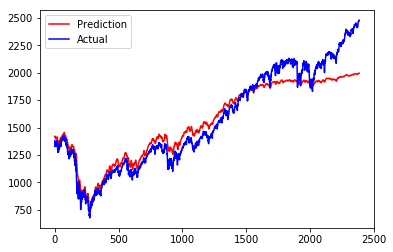

In [0]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

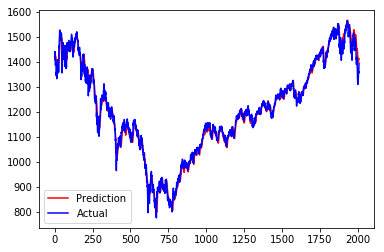

In [0]:
pt = model.predict(X_train)
new_pt = denormalize(df, pt)
newy_train = denormalize(df, y_train)

plt2.plot(new_pt,color='red', label='Prediction')
plt2.plot(newy_train,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

In [0]:
import matplotlib.pyplot as plt2

plt2.plot(model.predict(trainX),color='red', label='Prediction')
plt2.plot(trainY,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

In [0]:
import matplotlib.pyplot as plt2


plt2.plot(model.predict(testX),color='red', label='Prediction')
plt2.plot(testY,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()